In [10]:
!gdown --id 1c8k6cQ0P9HgkfoxgZx5jbn6e-6v0JRTO

/home/arpan/miniconda3/envs/prog/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1c8k6cQ0P9HgkfoxgZx5jbn6e-6v0JRTO
From (redirected): https://drive.google.com/uc?id=1c8k6cQ0P9HgkfoxgZx5jbn6e-6v0JRTO&confirm=t&uuid=7a3acebd-4ac9-49a3-b2c8-b6d6f9773b9d
To: /home/arpan/prog-rock/training_data.zip
100%|███████████████████████████████████████| 2.51G/2.51G [00:22<00:00, 111MB/s]


In [11]:
!mkdir content
!unzip -j training_data.zip -d ./content

Archive:  training_data.zip
  inflating: ./content/non_progressive_rock_songs_tensor.pt  
  inflating: ./content/progressive_rock_songs_tensor.pt  


In [1]:
import torch
from torchsummary import summary

#training tensors
prog_tensors = torch.load('./content/progressive_rock_songs_tensor.pt')
non_prog_tensors = torch.load('./content/non_progressive_rock_songs_tensor.pt')

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
print(" CUDA Version is ", get_device())

 CUDA Version is  cuda:0


In [2]:
prog_tensors = prog_tensors.float()
non_prog_tensors = non_prog_tensors.float()

In [3]:
data = torch.cat((prog_tensors, non_prog_tensors), dim=0)
labels = torch.cat((torch.ones(prog_tensors.shape[0]), torch.zeros(non_prog_tensors.shape[0])), dim=0)

In [4]:
batch_size = 32 

In [5]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset from your data and labels
train_dataset = TensorDataset(data, labels)
# Create DataLoader for each dataset with the specified batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


## Model 

In [23]:
import torch
import torch.nn as nn
# nn.Conv1d expects a batched 3-dimensional input in the shape [batch_size, in_channels, seq_length] or an unbatched 2-dimensional input in the shape [in_channels, seq_length]
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv1d(in_channels=160, out_channels=320, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(320)
        self.conv2 = nn.Conv1d(in_channels=320, out_channels=640, kernel_size=5, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(640)
        self.conv3 = nn.Conv1d(in_channels=640, out_channels=256, kernel_size=5, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm1d(128)

        # Define fully connected layers
        self.fc1 = nn.Linear(212*128, 200)  
        self.fc2 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(20, 2)

        # Define activation function
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = self.dropout(x)
        x = self.relu(self.batchnorm4(self.conv4(x)))
        x = self.dropout(x)

        # Flatten the output of the convolutional layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Instantiate the model
model = MyConvNet()
print(model)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (e.g., Adam optimizer with learning rate 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

MyConvNet(
  (conv1): Conv1d(160, 320, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(320, 640, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm2): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(640, 256, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=27136, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [24]:
from torchsummary import summary


In [25]:
print(summary(model, (160,216), 32, "cpu"))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [32, 320, 216]         153,920
       BatchNorm1d-2             [32, 320, 216]             640
              ReLU-3             [32, 320, 216]               0
           Dropout-4             [32, 320, 216]               0
            Conv1d-5             [32, 640, 214]       1,024,640
       BatchNorm1d-6             [32, 640, 214]           1,280
              ReLU-7             [32, 640, 214]               0
           Dropout-8             [32, 640, 214]               0
            Conv1d-9             [32, 256, 212]         819,456
      BatchNorm1d-10             [32, 256, 212]             512
             ReLU-11             [32, 256, 212]               0
          Dropout-12             [32, 256, 212]               0
           Conv1d-13             [32, 128, 212]          98,432
      BatchNorm1d-14             [32, 1

In [26]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
print(" CUDA Version is ", get_device())

 CUDA Version is  cuda:0


In [27]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
print(model)
device = get_device()
model.to(device)
model.train()
loss_hist = []
correct_predictions = 0
total_predictions = 0
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
epochs = 20

for e in range(epochs):
    i = 1
    loss_per_epoch = 0
    for inputs, labels in train_loader:
        # Perform forward pass, compute loss, and update the model
        inputs = inputs.unsqueeze(1)
        labels = labels.long()
        bs, c, time, feats = inputs.shape
        inputs = inputs.reshape(bs, feats, time)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss_per_epoch += loss.item()
        # Calculate accuracy
        # print('a',outputs.data)
        # print('b',torch.max(outputs.data, 1))
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Calculate precision
        true_positives += ((predicted == 1) & (labels == 1)).sum().item()
        false_positives += ((predicted == 1) & (labels == 0)).sum().item()
        true_negatives += ((predicted == 0) & (labels == 0)).sum().item()
        false_negatives += ((predicted == 0) & (labels == 1)).sum().item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print metrics
        print("Epoch: {}, Batch: {}, Loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%".format(
            e, i, loss.item(), (correct_predictions / total_predictions) * 100,
            (true_positives / (true_positives + false_positives + 1e-12)) * 100  # Add small epsilon to avoid division by zero
        ))

        i += 1
    loss_hist.append(loss_per_epoch/i)
    writer.add_scalar("Loss/gates", loss_per_epoch/i, e)
    writer.flush()
torch.save(model.state_dict(), "./model/gates/model.pt")


MyConvNet(
  (conv1): Conv1d(160, 320, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(320, 640, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm2): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(640, 256, kernel_size=(5,), stride=(1,), padding=(1,))
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchnorm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=27136, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)
Epoch: 0, Batch: 1, Loss: 0.6938, Accuracy: 53.12%, Precision:

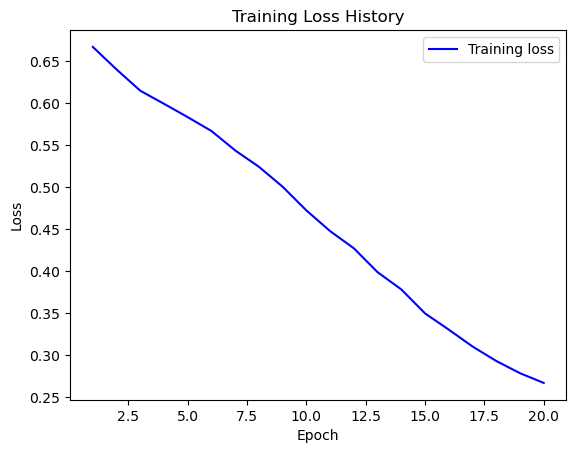

In [28]:
import matplotlib.pyplot as plt

# Create a list of epochs
epochs = range(1, len(loss_hist) + 1)

# Plot the training loss as a curve
plt.plot(epochs, loss_hist, 'b-', label='Training loss')

# Add a title and axis labels
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [29]:
# path warning!! Colab dir are different
prog_tensors_validation = torch.load('./test-tensors/progressive_rock_songs_test_tensor.pt')
non_prog_tensors_validation = torch.load('./test-tensors/non_progressive_rock_songs_test_tensor.pt')
# model/model_conv1d_norm_1_large.pt

In [30]:
# model = model_state_dict
model.eval()  # Set the model to evaluation mode
## For the song
device = get_device()
model.to("cpu")
prog_true = 0
prog_false = 0
non_prog_true = 0
non_prog_false = 0
# for the individual snippets
total_prog_true = 0
total_prog_false = 0
total_non_prog_true = 0
total_non_prog_false = 0
with torch.no_grad():  # Disable gradients during validation
  correct = 0
  total = 0
  for obj in prog_tensors_validation:
    total = len(obj)
    it = 0
    for i in obj:
      i = i.reshape(1,160,216)
      i = i.to("cpu")
      outputs = model(i)
      _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      if(predicted.item() == 1):
        it = it+1
    
    total_prog_true += it
    total_prog_false += (total-it)
    if(2*it >= total):
      prog_true +=1
    else:
      prog_false +=1
  for obj in non_prog_tensors_validation:
    total = len(obj)
    it = 0
    for i in obj:
      i = i.reshape(1,160,216)
      outputs = model(i)
      _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      if(predicted.item() == 0):
        it = it+1
    total_non_prog_true += it
    total_non_prog_false += (total-it)
    if(2*it >= total):
      non_prog_true +=1
    else:
      non_prog_false +=1


print(prog_true, prog_false)
print(non_prog_false, non_prog_true)

print(total_prog_true, total_prog_false)
print(total_non_prog_false, total_non_prog_true)

133 5
67 66
5399 1316
2219 1793


In [33]:
TP = prog_true
FN = prog_false
FP = non_prog_false
TN = non_prog_true

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate Precision for the progressive class
precision = TP / (TP + FP)

# Calculate Recall (Sensitivity) for the progressive class
recall = TP / (TP + FN)

# Calculate Specificity for the progressive class
specificity = TN / (TN + FP)

# Calculate F1 Score for the progressive class
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision (Progressive Class): {precision:.4f}")
print(f"Recall (Progressive Class): {recall:.4f}")
print(f"Specificity (Progressive Class): {specificity:.4f}")
print(f"F1 Score (Progressive Class): {f1_score:.4f}")

Accuracy: 73.43%
Precision (Progressive Class): 0.6650
Recall (Progressive Class): 0.9638
Specificity (Progressive Class): 0.4962
F1 Score (Progressive Class): 0.7870
